In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="../css/custom.css">

# Transfer learning for image classification

![footer_logo](../images/logo.png)

## Goal

- Use transfer learning to classify images
- Learn how to load images from disk

## Program

- [Pre-trained models available in Keras]()
    - [Inception]()
    - [MobileNet]()
    - [Classifying an image using a pre-trained network]()
    
    
- [The CIFAR-10 dataset]()
- [Transfer learning with pre-trained weights]()
- [Loading images from disk]()
- [Training and validating the model]()

In [2]:
import os
import random
import shutil

from pprint import pprint

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

from PIL import Image

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = 15, 6

---
## Pre-trained models available in Keras

There are several pre-trained models for image classification in Keras. Here is a summary:

![pre-trained models](../images/transfer_learning/pre_trained_models.png)

### <mark> Exercise: Pre-trained models
> 
> Have a look at the documentation about the different pre-trained models https://keras.io/applications/

### Inception V3

Inceoption V3 was trained for `imagenet` over 1000 classes. Check the classes it was trained on [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

![inception V3](../images/transfer_learning/inceptionV3.png)

### MobileNet

MobileNet is an architecture trained for `imagenet` over 1000 classes but is lighter weight and mobile-friendly network.
Check the classes it was trained on [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).
The architecture is given in the table below.

<figure style="text-align:center;">
    <img src="../images/transfer_learning/mobilenet.jpeg" width="700"/>
</figure>

### Classify an image using [`MobileNet`](https://keras.io/applications/#mobilenet)

The model will try to classify an image given the 1000 classes in [ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [4]:
from tensorflow.keras.applications.mobilenet import decode_predictions
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

In [26]:
model = MobileNet(weights="imagenet")  # this can take a bit
# model.summary()

Let's try it out on this image below.

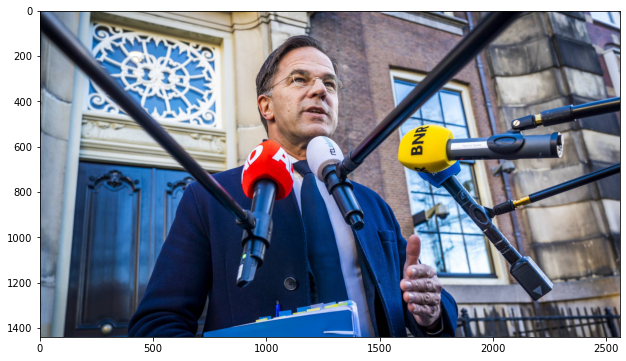

In [11]:
img_path = "../images/transfer_learning/scorpion.jpg"
img_path = "../images/transfer_learning/nos.jpg"
plt.imshow(mpimg.imread(img_path))

In [12]:
mpimg.imread(img_path).shape

(1440, 2560, 3)

By default it expects an image of input shape of `(224, 224, 3)`, so we'll process it a bit and then get the top predictions out.

In [15]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
best_preds = decode_predictions(preds, top=5)
preds = decode_predictions(model.predict(x), top=5)[0]

prediction = preds[0][1]
certainty = preds[0][2]
print(f'The prediction is {prediction} with {certainty:.6f} certainty.\n')
pprint(preds)


The prediction is power_drill with 0.247621 certainty.

[('n03995372', 'power_drill', 0.24762118),
 ('n03873416', 'paddle', 0.10003588),
 ('n01818515', 'macaw', 0.07054202),
 ('n04485082', 'tripod', 0.039011285),
 ('n04501370', 'turnstile', 0.036853194)]


### <mark> Exercise
>
> * Add your own image to the images folder and check what the predictions are.

In [16]:
del model

---
## CIFAR10 

MobileNet was trained on ImageNet and we'll re-train it on CIFAR10.
CIFAR 10 is a dataset with different image sizes and ten different classes.

In [19]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

170508288/170498071 [==============================] - 100s 1us/step


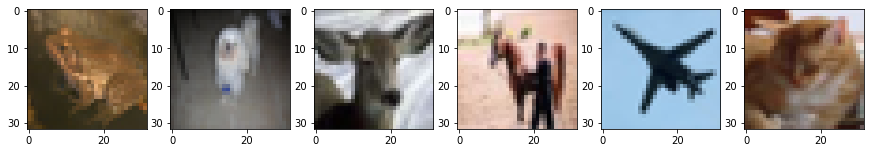

In [20]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
[ax.imshow(random.choice(X_train), cmap="gray") for ax in plt.subplots(1, 6)[1]]

To simulate a more realistic scenario I'll save the images to disk and we will ingest them from there to the model input

In [21]:
def save_keras_dataset_to_disk(X_train, y_train, X_test, y_test):
    for i, x_img in enumerate(X_train):
        label = y_train[i, 0]
        train_dir = f"../output/CIFAR10/train/{label}"
        os.makedirs(train_dir, exist_ok=True)
        Image.fromarray(x_img).save(os.path.join(train_dir, f"{i}.jpeg"))
    for i, x_img in enumerate(X_test):
        label = y_test[i, 0]
        test_dir = f"../output/CIFAR10/test/{label}"
        os.makedirs(test_dir, exist_ok=True)
        Image.fromarray(x_img).save(os.path.join(test_dir, f"{i}.jpeg"))
    print("Done!")


In [22]:
# takes around 1.5 minutes and occupies ~50MB
save_keras_dataset_to_disk(X_train, y_train, X_test, y_test)

Done!


If you navigate to `output/CIFAR10/`, you'll find that the directory structure is similar to the one given below.
There are two folders for test and train data.
Each class has its own subfolder with images belonging to that class in it.
This structure allows us to efficiently load images from disk later.

```
test/
    0/
        10.jpeg
        10008.jpeg
        ...
        9991.jpeg
    1/
        10000.jpeg
        10022.jpeg
        ...
        9998.jpeg
    ...
    9/
        1000.jpeg
        10030.jpeg
        ...
        9996.jpeg
train/
    0/
        10.jpeg
        1001.jpeg
        ...
        9991.jpeg
    1/
        1005.jpeg
        1006.jpeg
        ...
        9998.jpeg
    ...
    9/
        1008.jpeg
        1060.jpeg
        ...
        9971.jpeg
```

## Tranfer Learning with pre-trained weights

Without transfer learning you could re-use the architecture, but you would have to optimize all the weights from scratch.
Now, we'll keep the weights of all layers except the last layer.
This way, we use the convolutional filters learned by the model and only teach it to classify 10 different classes. 


Load the model without the last classification layer and set input_shape as close as possible to original data. Not all input shapes work, check the [documentation](https://keras.io/applications/#mobilenet).

In [28]:
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

In [27]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### <mark> Exercise
    
Compare the last layers with the full model loaded above. 
> Which layers are missing? Why is this the case?

Freeze the weights for all layers: we want to keep the learned filters.

In [29]:
for layer in base_model.layers:
    layer.trainable = False

### <mark> Exercise: add custom layers for our CIFAR10 dataset problem
 
Using the [`functional` API](https://keras.io/getting-started/functional-api-guide/) you will:
 
> - get the output from the base model
> - add `GlobalAveragePooling2D` layer
> - add `Dense` layer of 512 units
> - add output `Dense` layer with 10 units
> - put layers together into custom model

In [ ]:
# NBVAL_RAISES_EXCEPTION
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def make_custom_model(base_model):

    # get base model output
    x = base_model.output

    # add GlobalAveragePooling2D layer

    # add Dense layer of 512 units

    # add output Dense layer with 10 units and softmax activation function

    # put layers together into custom model
    model = Model(inputs=inputs, outputs=predictions)
    return model


model = make_custom_model(base_model)
model.summary()

In [31]:
# %load ../answers/transfer_learning.py
from tensorflow.keras import layers
from tensorflow.keras.models import Model


def make_custom_model(base_model):
    # get base model output
    x = base_model.output
    # add GlobalAveragePooling2D layer
    x = layers.GlobalAveragePooling2D()(x)
    # add Dense layer of 512 units
    x = layers.Dense(units=512, activation="relu")(x)
    # add output Dense layer with 10 units and softmax activation function
    predictions = layers.Dense(units=10, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


model = make_custom_model(base_model)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

### <mark> Exercise: Trainable parameters
>
> Check how many trainable parameters in the summary, does it make sense?

Print only the trainable layers:

In [32]:
for l in model.layers:
    if l.trainable:
        print(l)

Let's compile the model. We're using the categorical crossentropy because we're classifying with multiple classes.

In [33]:
model = make_custom_model(base_model)
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Loading images from disk

We'll use the [`ImageDataGenerator`](https://keras.io/preprocessing/image/) to load images from disk.

### <mark> Exercise: Initiate the generator
Implement [`ImageDataGenerator`](https://keras.io/preprocessing/image/) below such that:
> - pixel values are re-scaled in the interval 0 to 1
> - the missing pixels are filled with 0 when changing the image size

In [ ]:
train_datagen = image.ImageDataGenerator(...)

In [35]:
# %load ../answers/transfer_image_generator.py
train_datagen = image.ImageDataGenerator(rescale=1.0 / 255, fill_mode="k",)

### <mark>Exercise: Flow `CIFAR10` data from file
 
Implement [`ImageDataGenerator.flow_from_directory`](https://keras.io/preprocessing/image/) such that:
> - we read the images from `../output/CIFAR10/train` and `../output/CIFAR10/test`
> - the target size is set to 128x128
> - ensure shuffle
> - and the batch size is set by us

In [ ]:
# NBVAL_RAISES_EXCEPTION
batch_size = 50
train_generator = train_datagen.flow_from_directory(
    # fill here
)

test_generator = train_datagen.flow_from_directory(
    # fill here
)

In [37]:
# %load ../answers/cifar_flow.py
batch_size = 50

train_generator = train_datagen.flow_from_directory(
    directory="../output/CIFAR10/train/",
    target_size=(128, 128),
    shuffle=True,
    batch_size=batch_size,
)
test_generator = train_datagen.flow_from_directory(
    directory="../output/CIFAR10/test/",
    target_size=(128, 128),
    shuffle=True,
    batch_size=batch_size,
)


Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


## Training and validating the model

### <mark> Exercise: fit using the generator
> 
> Use  [`Sequential.fit`](https://keras.io/models/sequential/) such that:
> - we ingest images using the `train_generator`
> - train for 5 `epochs`
> - use 10 `steps_per_epoch`

In [ ]:
# NBVAL_RAISES_EXCEPTION
summary = model.fit(
    # fill here
)

In [39]:
# %load ../answers/cifar_fit.py
model.fit(
    train_generator,
    verbose=1,
    epochs=10,
    steps_per_epoch=10,
    validation_data=test_generator,
    validation_steps=10,
)


Epoch 1/10
10/10 [==============================] - 10s 935ms/step - loss: 2.1307 - accuracy: 0.3020 - val_loss: 1.5316 - val_accuracy: 0.4320
Epoch 2/10
10/10 [==============================] - 8s 805ms/step - loss: 1.3897 - accuracy: 0.5000 - val_loss: 1.1335 - val_accuracy: 0.6380
Epoch 3/10
10/10 [==============================] - 8s 866ms/step - loss: 1.2295 - accuracy: 0.5740 - val_loss: 1.1494 - val_accuracy: 0.6100
Epoch 4/10
10/10 [==============================] - 8s 790ms/step - loss: 0.9851 - accuracy: 0.6420 - val_loss: 1.1818 - val_accuracy: 0.6000
Epoch 5/10
10/10 [==============================] - 7s 754ms/step - loss: 1.0463 - accuracy: 0.6220 - val_loss: 0.9515 - val_accuracy: 0.6840
Epoch 6/10
10/10 [==============================] - 8s 789ms/step - loss: 1.0198 - accuracy: 0.6520 - val_loss: 0.9774 - val_accuracy: 0.6420
Epoch 7/10
10/10 [==============================] - 9s 918ms/step - loss: 0.8594 - accuracy: 0.6820 - val_loss: 0.9301 - val_accuracy: 0.6580
Epoch

---
## Summary

We've seen how we can use a pre-trained neural network on a new dataset.
In addition, we have learned to efficiently load images from disk with Keras.

In [ ]:
shutil.rmtree("../output")